- Similar to umap_kmeans
- Includes tuning of umap and cluster params

Results:
- K = 13 gives the best silhouette score.
- Elbow point is around k=5 ++

In [1]:
# Imports

from pathlib import Path
from collections import Counter
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import hdbscan
import umap.umap_ as umap
import yake

from tqdm import tqdm


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_kmean_tuned"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [6]:
# Embed all abstracts in batches

texts = df["clean_abs"].astype(str).tolist()
batch_size = 256

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=len(batch)
    )
    embeddings.append(batch_emb)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)


Embedding abstracts: 100%|██████████| 130/130 [02:55<00:00,  1.35s/it]

Embedding matrix shape: (33130, 768)


In [7]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


Saved embeddings to: ../../data/processed/abstracts/umap_kmean_tuned/abstract_embeddings.npy


In [8]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [9]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


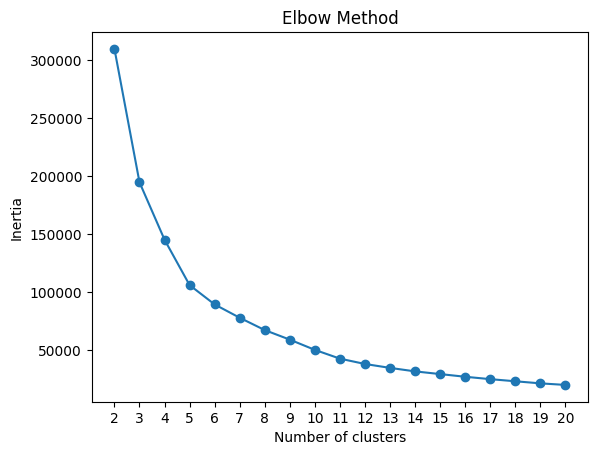

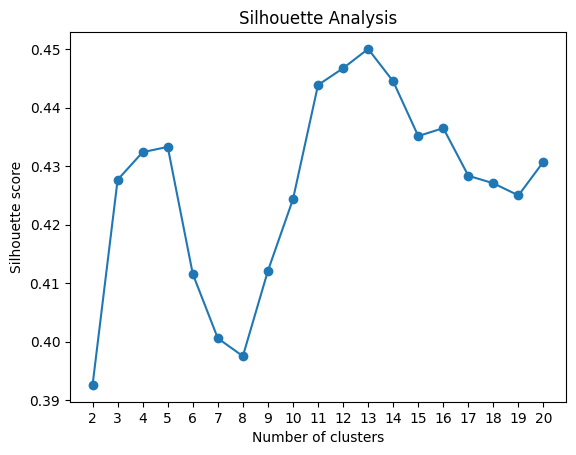

kmeans_cluster
0     4340
1     3045
2     2328
3     2857
4     1045
5     2056
6     2280
7     1566
8     2057
9     2204
10    2323
11    3467
12    3562
Name: count, dtype: int64


In [10]:
# UMAP output used for clustering
X = umap_coords

# Test different numbers of clusters
k_values = range(2, 21)

# Elbow method
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot inertia
plt.figure()
plt.plot(list(k_values), inertias, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.xticks(list(k_values))
plt.show()

# Silhouette method
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette score
plt.figure()
plt.plot(list(k_values), silhouette_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")
plt.xticks(list(k_values))
plt.show()

# Example: apply chosen number of clusters
best_k = 13
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Add labels to dataframe
df["kmeans_cluster"] = kmeans_labels
print(df["kmeans_cluster"].value_counts().sort_index())


In [11]:
# Apply chosen number of clusters
k = 13
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Add labels to dataframe
df["kmeans_cluster"] = kmeans_labels
print(df["kmeans_cluster"].value_counts().sort_index())

kmeans_cluster
0     4340
1     3045
2     2328
3     2857
4     1045
5     2056
6     2280
7     1566
8     2057
9     2204
10    2323
11    3467
12    3562
Name: count, dtype: int64


In [12]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_clusters.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with clusters to: {out_path}")

Saved dataset with clusters to: ../../data/processed/abstracts/umap_kmean_tuned/abstracts_with_clusters.csv


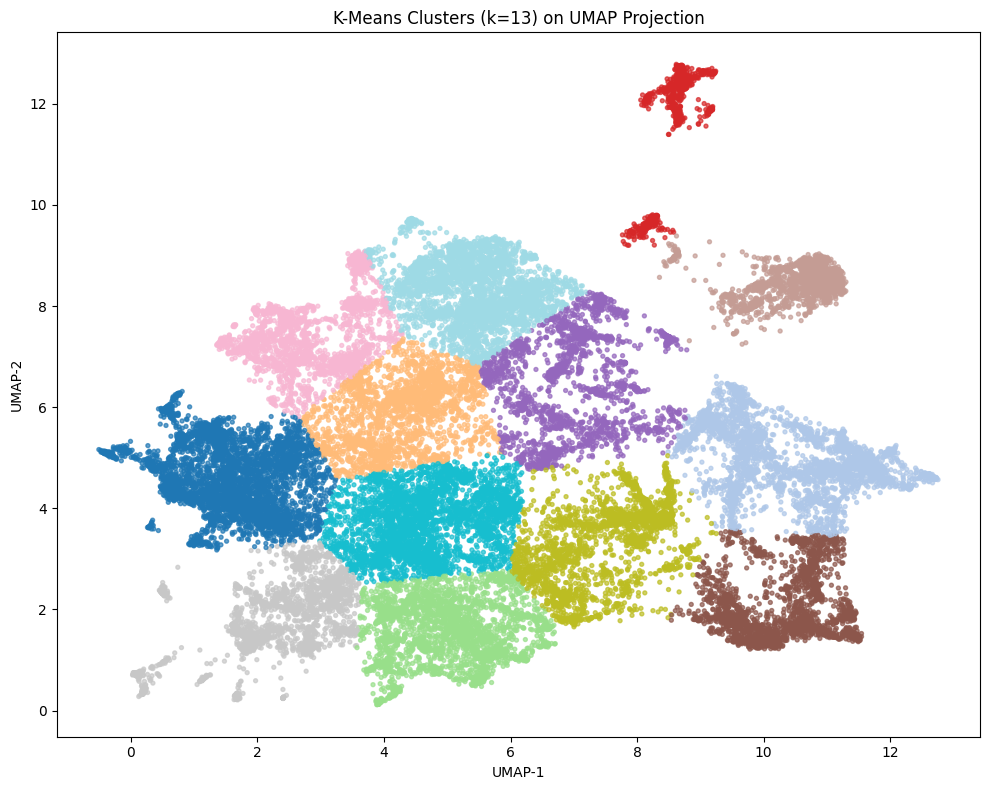

In [13]:
# Plot K-Means clusters on UMAP projection

plt.figure(figsize=(10,8))
plt.scatter(
    df["umap_x"], df["umap_y"],
    c=df["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title(f"K-Means Clusters (k={k}) on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


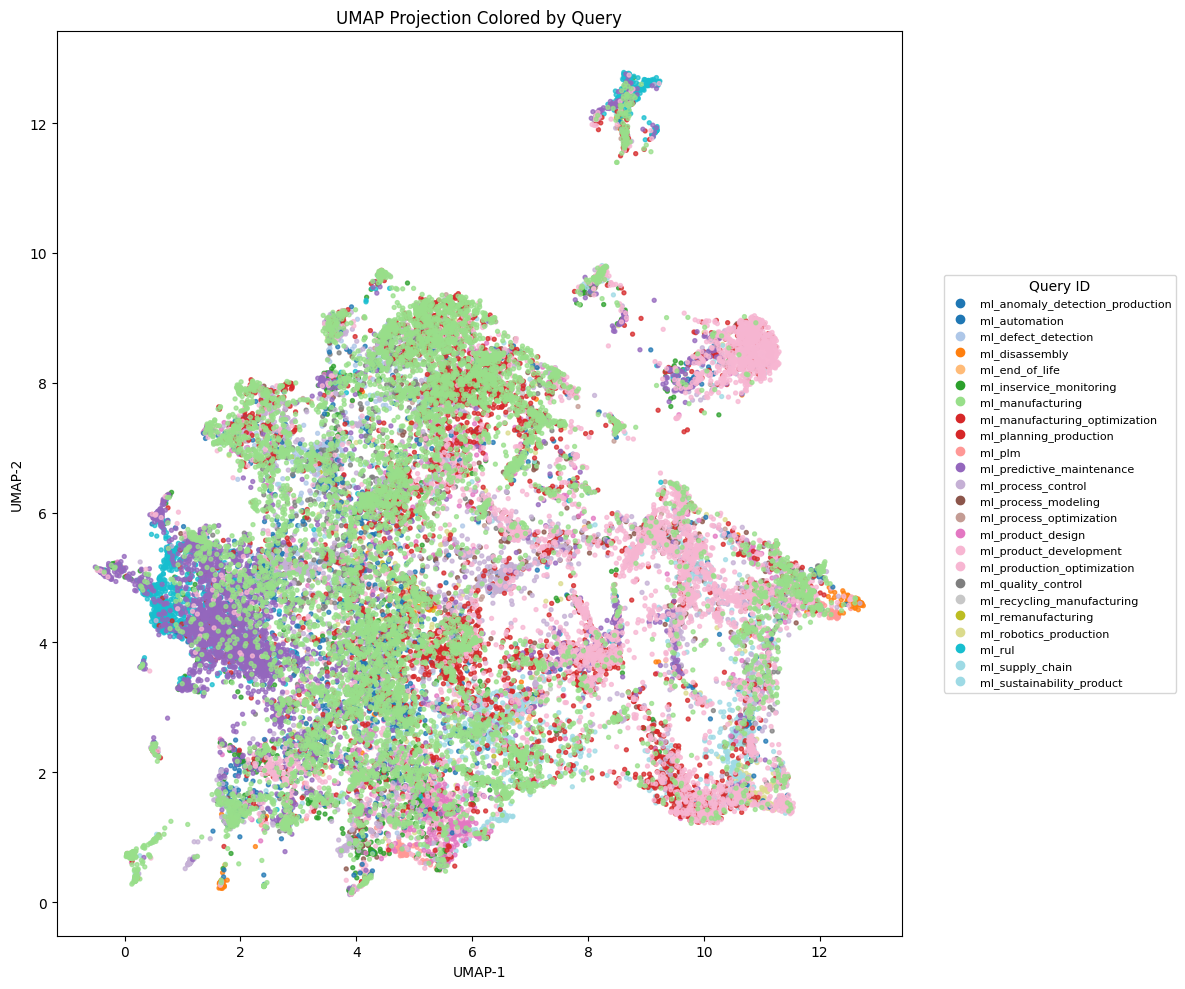

In [14]:
# Plot query_id distribution on UMAP projection

# Assign an integer color index to each query_id
query_ids = df["query_id"].astype("category")
query_labels = query_ids.cat.codes  # numeric mapping

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df["umap_x"], df["umap_y"],
    c=query_labels,
    cmap="tab20",   # adjust depending on number of queries (>20 => use tab20b + tab20c)
    s=8,
    alpha=0.75
)

# Legend mapping numeric labels → query_id names
handles = []
for code, name in enumerate(query_ids.cat.categories):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", 
                   color=scatter.cmap(scatter.norm(code)), label=name)
    )

plt.legend(
    handles=handles,
    title="Query ID",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.,
    fontsize=8
)

plt.title("UMAP Projection Colored by Query")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [15]:
domain_stopwords = {
    # Generic ML terms
    "machine learning", "ml", "deep learning", "data", "dataset", "model",
    "models", "method", "methods", "technique", "techniques", 'machine',
    "approach", "algorithm", "algorithms", "neural network",
    "artificial neural network", "support vector machine",
    "random forest", "learning approach", "learning algorithms",
    "deep learning models", "convolutional neural network", 'machine learning approach', 
    'machine learning techniques', 'machine learning models', 'machine learning algorithms', 'machine learning methods', 
    'machine learning approach', 'neural network model', 'Support Vector Regression', 'extreme learning machine', 
    'learning models', 'advanced machine learning', 'machine learning tools', 'ai',
    

    # Publisher names + garbage
    "springer nature switzerland", "springer nature singapore",
    "elsevier", "ieee", "wiley", "mdpi",
    
    "based", 'system', 'systems', 'using', 'paper', 'tool'
}

In [16]:
# kw_extractor = yake.KeywordExtractor(
#     lan="en",
#     n=3,  # max length of keyword: allows bigrams & trigrams
#     top=20,
#     dedupLim=0.3
# )

# def get_cluster_keywords(cluster_id, top_k=10):
#     texts = df[df["kmeans_cluster"] == cluster_id]["clean_abs"].tolist()
#     full_text = " ".join(texts)
    
#     keywords = kw_extractor.extract_keywords(full_text)
#     keywords = [
#         kw for kw, score in sorted(keywords, key=lambda x: x[1])
#         if kw.lower() not in domain_stopwords
#     ]
    
#     return keywords[:top_k]

# for cid in range(k):
#     print(f"\nCluster {cid}:")
#     print(get_cluster_keywords(cid, 12))



In [17]:
# Fit TF-IDF on all abstracts once
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 3),
    stop_words="english"
)
X = vectorizer.fit_transform(df["clean_abs"].astype(str))
feature_names = np.array(vectorizer.get_feature_names_out())


In [18]:
def get_cluster_tfidf_keywords(cluster_id, top_k=15):
    # Boolean mask as numpy array (needed for sparse matrix indexing)
    mask = (df["kmeans_cluster"] == cluster_id).values
    if mask.sum() == 0:
        return []

    X_cluster = X[mask]

    # Mean TF-IDF score per term in this cluster
    mean_tfidf = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1]

    keywords = []
    for idx in top_idx:
        kw = feature_names[idx].lower()
        if kw in domain_stopwords:
            continue
        keywords.append(kw)
        if len(keywords) == top_k:
            break

    return keywords

# Test on a few clusters
for cid in range(k):
    print(f"\nCluster {cid}:")
    print(get_cluster_tfidf_keywords(cid, 12))


Cluster 0:
['maintenance', 'predictive maintenance', 'predictive', 'fault', 'failure', 'equipment', 'detection', 'rul', 'time', 'industrial', 'prediction', 'proposed']

Cluster 1:
['process', 'production', 'hydrogen', 'optimization', 'energy', 'drug', 'cell', 'biomass', 'chemical', 'design', 'development', 'review']

Cluster 2:
['process', 'quality', 'machining', 'manufacturing', 'cutting', 'control', 'wear', 'surface', 'processes', 'product', 'time', 'production']

Cluster 3:
['product', 'design', 'business', 'research', 'process', 'customer', 'development', 'service', 'intelligence', 'study', 'software', 'analysis']

Cluster 4:
['battery', 'concrete', 'batteries', 'rul', 'ion', 'lithium', 'prediction', 'lithium ion', 'strength', 'life', 'ion batteries', 'cement']

Cluster 5:
['process', 'design', 'control', 'optimization', 'materials', 'performance', 'parameters', '3d', 'high', 'manufacturing', 'printing', 'production']

Cluster 6:
['food', 'crop', 'agricultural', 'agriculture', 'pr

In [19]:
# Dominant query per cluster
df.groupby("kmeans_cluster")["query_id"].apply(
    lambda x: x.value_counts().idxmax()
)

kmeans_cluster
0      ml_predictive_maintenance
1     ml_production_optimization
2               ml_manufacturing
3               ml_manufacturing
4                         ml_rul
5               ml_manufacturing
6     ml_production_optimization
7     ml_production_optimization
8               ml_manufacturing
9               ml_manufacturing
10    ml_production_optimization
11              ml_manufacturing
12              ml_manufacturing
Name: query_id, dtype: object

In [20]:
# Get top 1 most representative article per K-Means cluster (title + DOI only)

def get_representative_top1(df, embeddings, cluster_col="kmeans_cluster"):
    reps = []

    for cid in sorted(df[cluster_col].unique()):
        mask = (df[cluster_col] == cid).values
        if mask.sum() == 0:
            continue

        emb_sub = embeddings[mask]
        centroid = emb_sub.mean(axis=0, keepdims=True)
        sims = cosine_similarity(emb_sub, centroid).ravel()

        best_local = sims.argmax()
        global_idx = df.index[mask][best_local]

        reps.append({
            "cluster": cid,
            "similarity": sims[best_local],
            "query_id": df.at[global_idx, "query_id"],
            "title": df.at[global_idx, "title"],
            "doi": df.at[global_idx, "doi"]
        })

    return pd.DataFrame(reps)

# Compute
rep_top1 = get_representative_top1(df, embeddings)

for _, row in rep_top1.sort_values("cluster").iterrows():
    print(f"\n Cluster {row['cluster']} ")
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Query: {row['query_id']}")
    print(f"Title: {row['title']}")
    if pd.notna(row['doi']):
        print(f"DOI: https://doi.org/{row['doi']}")
    else:
        print("DOI: Not available")




 Cluster 0 
Similarity: 0.914
Query: ml_predictive_maintenance
Title: Predictive Analysis Development Using Machine Learning for Industrial Equipments
DOI: https://doi.org/10.1109/INCIP64058.2025.11020528

 Cluster 1 
Similarity: 0.831
Query: ml_process_control
Title: Recent advances in machine learning for biomanufacturing of chemicals
DOI: https://doi.org/10.11949/0438-1157.20250043

 Cluster 2 
Similarity: 0.884
Query: ml_quality_control
Title: Bewertung von mit maschinellem Lernen erzielten Qualitätsprognosen durch die Anwendung von etablierten Verfahren zum Nachweis der Messprozessfähigkeit in der Fertigung
DOI: https://doi.org/10.1515/teme-2021-0125

 Cluster 3 
Similarity: 0.844
Query: ml_sustainability_product
Title: AI and ML-based decision models and their effective utilisation across interdisciplinary applications
DOI: https://doi.org/10.1201/9781003621102-4

 Cluster 4 
Similarity: 0.888
Query: ml_rul
Title: Overview of machine learning methods for lithium-ion battery rema

In [21]:
# Compute dominant cluster statistics per query_id

# Basic group for top cluster per query
query_cluster_stats = (
    df.groupby("query_id")
      .agg(
          total_in_query=("kmeans_cluster", "size"),
          top_cluster=("kmeans_cluster", lambda x: x.value_counts().idxmax())
      )
)


def compute_both_shares(row):
    qid = row.name
    top_c = row["top_cluster"]

    # All articles for this query
    subset_query = df[df["query_id"] == qid]
    top_count_query = (subset_query["kmeans_cluster"] == top_c).sum()

    # All articles in top cluster
    subset_cluster = df[df["kmeans_cluster"] == top_c]
    top_count_cluster = (subset_cluster["query_id"] == qid).sum()

    share_of_query = top_count_query / row["total_in_query"]
    share_of_cluster = top_count_cluster / len(subset_cluster)

    return pd.Series([
        top_count_query,
        share_of_query,
        share_of_cluster,
        len(subset_cluster)
    ], index=[
        "top_count_query",
        "share_of_query",
        "share_of_cluster",
        "total_in_cluster"
    ])


# Apply computation
query_cluster_stats = query_cluster_stats.join(
    query_cluster_stats.apply(compute_both_shares, axis=1)
)

# Sort by how dominant cluster is for this query
query_cluster_stats = query_cluster_stats.sort_values("share_of_query", ascending=False)

query_cluster_stats


,total_in_query,top_cluster,top_count_query,share_of_query,share_of_cluster,total_in_cluster
query_id,,,,,,
ml_rul,1405,0,891.0,0.634164,0.205300,4340.0
ml_predictive_maintenance,3050,0,1891.0,0.620000,0.435714,4340.0
ml_end_of_life,51,10,23.0,0.450980,0.009901,2323.0
ml_disassembly,271,1,122.0,0.450185,0.040066,3045.0
ml_product_development,781,3,341.0,0.436620,0.119356,2857.0
ml_defect_detection,610,8,256.0,0.419672,0.124453,2057.0
ml_process_optimization,572,12,238.0,0.416084,0.066816,3562.0
ml_plm,229,3,93.0,0.406114,0.032552,2857.0
ml_anomaly_detection_production,610,0,247.0,0.404918,0.056912,4340.0
